# Fiedler Perturbation Analysis for Graph-Based Differential Privacy

**Literature**: Greenbaum, Li, Overton (2020) *First-Order Perturbation Theory for Eigenvalues and Eigenvectors*

### Key Improvements:
1. **Laplacian noise** (not Gaussian)
2.  **Frobenius norm scaling**
3.  **First non-zero eigenvalue detection**
4.  **First-order perturbation theory**
5.  **Privacy-utility tradeoff analysis**

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from scipy.linalg import eigh
from scipy.stats import laplace

from fiedler_perturbation_analysis import FiedlerPerturbationAnalyzer
from optimal_k_selector import OptimalKSelector

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

## 1. Load and Prepare Data
Using Iris dataset (same as original code)

In [19]:
# Load Iris data
df = pd.read_csv("Iris.csv")

X = df[['SepalLengthCm', 'SepalWidthCm',
              'PetalLengthCm', 'PetalWidthCm']].values
y = df['Species'].astype('category').cat.codes.values

print("Data shape:", X.shape)
print("Unique labels:", np.unique(y))

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Data shape: (150, 4)
Unique labels: [0 1 2]


## 2. Build Graph and Compute Laplacian
**Literature Reference**: Graph Laplacian L = D - A where:
- A = adjacency matrix
- D = degree matrix (diagonal)
- L has properties: symmetric, positive semi-definite, smallest eigenvalue = 0

In [20]:
# Build k-NN graph
selector = OptimalKSelector(X)
results = selector.analyze_k_range(k_min=5, k_max=20)
recommendations = selector.recommend_k(results)
k = int(recommendations['overall_best']['k'])

print("Optimal k recommendations:", recommendations)
print("Overall best k:",k)
A = kneighbors_graph(
    X_scaled,
    n_neighbors=k,
    mode="connectivity",
    include_self=False
).toarray()

# Ensure symmetry
A = np.maximum(A, A.T)

# Compute Laplacian
D = np.diag(A.sum(axis=1))
L = D - A

print(f"Graph: {A.shape[0]} nodes, {int(A.sum()/2)} edges")
print(f"Laplacian Frobenius norm: {np.linalg.norm(L, 'fro'):.4f}")
print(f"Laplacian row sums (should be ~0): {L.sum(axis=1)[:5]}")

Dataset: n=150 samples, d=4 features

Analyzing k ∈ [5, 20] (step=1)...
--------------------------------------------------------------------------------
k=  5 ✓ connected 
k=  6 ✓ connected k=  7 ✓ connected k=  8 ✓ connected k=  9 ✓ connected k= 10 ✓ connected 
k= 11 ✓ connected k= 12 ✓ connected k= 13 ✓ connected k= 14 ✓ connected k= 15 ✓ connected 
k= 16 ✓ connected k= 17 ✓ connected k= 18 ✓ connected k= 19 ✓ connected k= 20 ✓ connected 

--------------------------------------------------------------------------------
Optimal k recommendations: {'min_connected': {'k': np.int64(5), 'reason': 'Smallest k that ensures connectivity'}, 'max_spectral_gap': {'k': np.int64(20), 'gap': np.float64(2.367121307617417), 'reason': 'Maximizes gap between λ₂ and λ₃ (clearest clustering)'}, 'target_fiedler': {'k': np.int64(20), 'fiedler': np.float64(0.10215989016155902), 'reason': 'Fiedler value closest to target 0.3'}, 'elbow': {'k': np.int64(16), 'reason': 'Elbow point (diminishing returns)'}, 'lo

## 3. Initialize Perturbation Analyzer

In [16]:
# Initialize analyzer (automatically finds Fiedler value)
analyzer = FiedlerPerturbationAnalyzer(L, tol=1e-10)

print(f"\n✓ Fiedler value (connectivity): {analyzer.lambda0:.6f}")
print(f"  Interpretation: {'Weakly connected' if analyzer.lambda0 < 0.1 else 'Strongly connected'} graph")

  Zero eigenvalues: 1
  First 5 eigenvalues: [-3.55271368e-15  2.18901873e-02  1.72023084e-01  2.30733682e-01
  5.50362648e-01]
✓ Laplacian initialized (150×150)
✓ Fiedler value λ₀ = 0.021890 (index 1)
✓ Spectral gap: 0.150133

✓ Fiedler value (connectivity): 0.021890
  Interpretation: Weakly connected graph


## 5. Compare: Laplacian vs Gaussian Noise

In [5]:
# Comparison: Different noise types
epsilon = 1.0
kappa = 0.1
n = L.shape[0]

# 1. Laplacian noise (CORRECT - what we implemented)
frobenius_norm = np.linalg.norm(L, 'fro')
scale_laplacian = frobenius_norm / epsilon
noise_laplacian = laplace.rvs(loc=0, scale=scale_laplacian, size=(n, n))
noise_laplacian = (noise_laplacian + noise_laplacian.T) / 2

# 2. Gaussian noise (OLD - from original code)
noise_level = 0.05
noise_gaussian = noise_level * np.random.randn(n, n)
noise_gaussian = (noise_gaussian + noise_gaussian.T) / 2

# Apply both
L_laplacian = L + kappa * noise_laplacian
L_gaussian = L + kappa * noise_gaussian

# Compute Fiedler values
eigvals_lap, eigvecs_lap = eigh(L_laplacian)
eigvals_gauss, eigvecs_gauss = eigh(L_gaussian)

# Find Fiedler indices
fiedler_idx_lap = analyzer._find_fiedler_index_perturbed(eigvals_lap)
fiedler_idx_gauss = analyzer._find_fiedler_index_perturbed(eigvals_gauss)

print("\nNoise Comparison:")
print(f"Original Fiedler value: {analyzer.lambda0:.6f}")
print(f"Laplacian noise → {eigvals_lap[fiedler_idx_lap]:.6f} (change: {eigvals_lap[fiedler_idx_lap]-analyzer.lambda0:.6f})")
print(f"Gaussian noise  → {eigvals_gauss[fiedler_idx_gauss]:.6f} (change: {eigvals_gauss[fiedler_idx_gauss]-analyzer.lambda0:.6f})")
print(f"\nLaplacian noise has {'stronger' if abs(eigvals_lap[fiedler_idx_lap]-analyzer.lambda0) > abs(eigvals_gauss[fiedler_idx_gauss]-analyzer.lambda0) else 'weaker'} privacy protection")


Noise Comparison:
Original Fiedler value: 0.102160
Laplacian noise → -750.961122 (change: -751.063282)
Gaussian noise  → 0.001269 (change: -0.100891)

Laplacian noise has stronger privacy protection


## 6. Privacy-Utility Tradeoff Analysis

✓ Laplacian noise generated (ε=0.100, scale=3209.423624)
  Frobenius norm of noise: 657645.914934
✓ Laplacian noise generated (ε=0.221, scale=1453.323905)
  Frobenius norm of noise: 305268.987532
✓ Laplacian noise generated (ε=0.342, scale=939.343500)
  Frobenius norm of noise: 207298.384854
✓ Laplacian noise generated (ε=0.463, scale=693.929432)
  Frobenius norm of noise: 145946.013118
✓ Laplacian noise generated (ε=0.583, scale=550.186907)
  Frobenius norm of noise: 116220.129251
✓ Laplacian noise generated (ε=0.704, scale=455.776136)
  Frobenius norm of noise: 93077.602030
✓ Laplacian noise generated (ε=0.825, scale=389.021045)
  Frobenius norm of noise: 83463.106805
✓ Laplacian noise generated (ε=0.946, scale=339.322322)
  Frobenius norm of noise: 72175.713496
✓ Laplacian noise generated (ε=1.067, scale=300.883465)
  Frobenius norm of noise: 64062.029298
✓ Laplacian noise generated (ε=1.188, scale=270.267253)
  Frobenius norm of noise: 56359.367362
✓ Laplacian noise generated (ε=1.

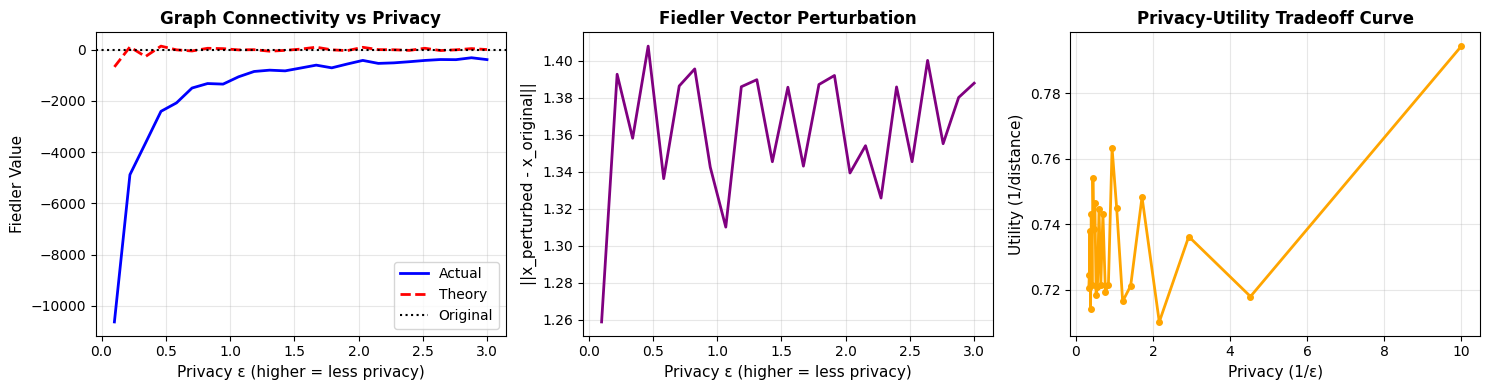


✓ Privacy-utility analysis complete for 25 privacy levels


In [6]:
# Sweep across privacy levels
epsilon_range = np.linspace(0.1, 3.0, 25)
kappa = 0.1

# Storage for results
fiedler_values = []
vector_distances = []
theoretical_predictions = []

for eps in epsilon_range:
    # Generate Laplacian noise
    L1 = analyzer.generate_laplacian_noise(eps)

    # Theoretical prediction
    lambda1_theory = analyzer.first_order_eigenvalue_perturbation(L1)
    theoretical_predictions.append(analyzer.lambda0 + kappa * lambda1_theory)

    # Actual computation
    L_perturbed = L + kappa * L1
    eigvals_p, eigvecs_p = eigh(L_perturbed)
    idx = analyzer._find_fiedler_index_perturbed(eigvals_p)

    fiedler_values.append(eigvals_p[idx])

    # Eigenvector distance
    x_p = eigvecs_p[:, idx]
    if np.dot(x_p, analyzer.x0) < 0:
        x_p = -x_p
    vector_distances.append(np.linalg.norm(x_p - analyzer.x0))

# Plot privacy-utility tradeoff
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Fiedler value vs privacy
axes[0].plot(epsilon_range, fiedler_values, 'b-', linewidth=2, label='Actual')
axes[0].plot(epsilon_range, theoretical_predictions, 'r--', linewidth=2, label='Theory')
axes[0].axhline(analyzer.lambda0, color='k', linestyle=':', label='Original')
axes[0].set_xlabel('Privacy ε (higher = less privacy)', fontsize=11)
axes[0].set_ylabel('Fiedler Value', fontsize=11)
axes[0].set_title('Graph Connectivity vs Privacy', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Vector perturbation
axes[1].plot(epsilon_range, vector_distances, 'purple', linewidth=2)
axes[1].set_xlabel('Privacy ε (higher = less privacy)', fontsize=11)
axes[1].set_ylabel('||x_perturbed - x_original||', fontsize=11)
axes[1].set_title('Fiedler Vector Perturbation', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Plot 3: Privacy-Utility tradeoff
# Utility = 1 / vector_distance (higher is better)
utility = 1.0 / (np.array(vector_distances) + 1e-6)
privacy = 1.0 / epsilon_range  # Higher privacy parameter = lower privacy

axes[2].plot(privacy, utility, 'orange', linewidth=2, marker='o', markersize=4)
axes[2].set_xlabel('Privacy (1/ε)', fontsize=11)
axes[2].set_ylabel('Utility (1/distance)', fontsize=11)
axes[2].set_title('Privacy-Utility Tradeoff Curve', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('privacy_utility_tradeoff.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Privacy-utility analysis complete for {len(epsilon_range)} privacy levels")

## 7. Fiedler Vector Stability Visualization
**From original code** - but with proper Laplacian noise

✓ Laplacian noise generated (ε=1.000, scale=320.942362)
  Frobenius norm of noise: 65522.794407


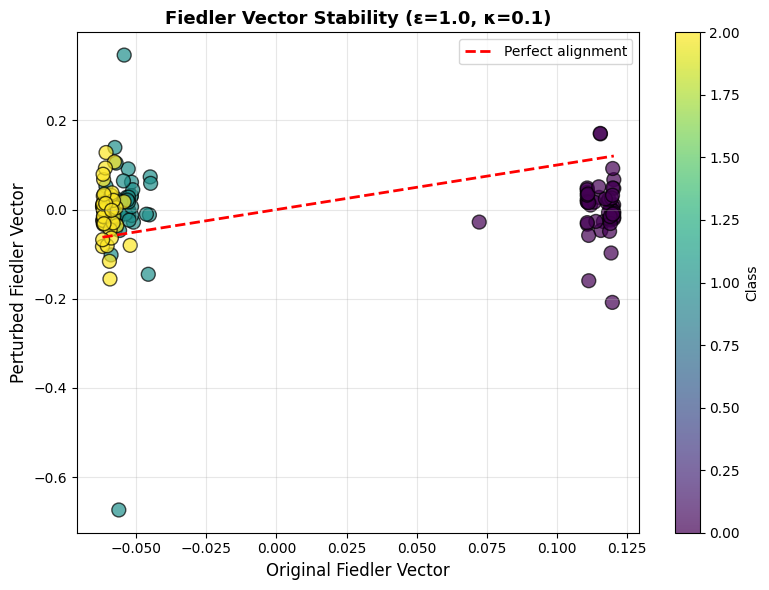


Vector distance: 1.388440
Cosine similarity: 0.036117


In [7]:
# Compare original vs perturbed Fiedler vectors
epsilon = 1.0
kappa = 0.1

# Generate noise and perturb
L1 = analyzer.generate_laplacian_noise(epsilon)
L_perturbed = L + kappa * L1
eigvals_p, eigvecs_p = eigh(L_perturbed)
idx = analyzer._find_fiedler_index_perturbed(eigvals_p)
fiedler_perturbed = eigvecs_p[:, idx]

# Align sign
if np.dot(fiedler_perturbed, analyzer.x0) < 0:
    fiedler_perturbed = -fiedler_perturbed

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(analyzer.x0, fiedler_perturbed, c=y, cmap='viridis', s=100, alpha=0.7, edgecolors='k')
plt.plot([analyzer.x0.min(), analyzer.x0.max()],
         [analyzer.x0.min(), analyzer.x0.max()],
         'r--', linewidth=2, label='Perfect alignment')
plt.xlabel('Original Fiedler Vector', fontsize=12)
plt.ylabel('Perturbed Fiedler Vector', fontsize=12)
plt.title(f'Fiedler Vector Stability (ε={epsilon}, κ={kappa})', fontsize=13, fontweight='bold')
plt.legend()
plt.colorbar(label='Class')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('fiedler_vector_stability.png', dpi=150, bbox_inches='tight')
plt.show()

# Compute distance
distance = np.linalg.norm(analyzer.x0 - fiedler_perturbed)
cosine_sim = np.dot(analyzer.x0, fiedler_perturbed) / (np.linalg.norm(analyzer.x0) * np.linalg.norm(fiedler_perturbed))
print(f"\nVector distance: {distance:.6f}")
print(f"Cosine similarity: {cosine_sim:.6f}")

## 8. Connectivity Analysis Using Fiedler Value
**Professor Feedback**: "can we find a way to do the connectivity of graph using fiedler value?"

**Answer**: Yes! The Fiedler value (algebraic connectivity) measures how well-connected a graph is:
- λ₂ = 0 → Disconnected graph
- Small λ₂ → Weakly connected (easy to partition)
- Large λ₂ → Strongly connected (hard to partition)

**Machine Learning Impact**:
- High connectivity → Hard to separate data → Lower ML accuracy
- Low connectivity → Easy to separate data → Higher ML accuracy

In [8]:
# Analyze how privacy noise affects connectivity
print("\n" + "="*70)
print("CONNECTIVITY ANALYSIS")
print("="*70)

print(f"\nOriginal graph:")
print(f"  Fiedler value (λ₂): {analyzer.lambda0:.6f}")
print(f"  Connectivity: {'WEAK' if analyzer.lambda0 < 0.1 else 'MODERATE' if analyzer.lambda0 < 0.5 else 'STRONG'}")
print(f"  ML prediction: {'EASIER separation (higher accuracy)' if analyzer.lambda0 < 0.3 else 'HARDER separation (lower accuracy)'}")

# Test different privacy levels
test_epsilons = [0.5, 1.0, 2.0]
kappa = 0.1

for eps in test_epsilons:
    L1 = analyzer.generate_laplacian_noise(eps)
    L_p = L + kappa * L1
    eigvals_p, _ = eigh(L_p)
    idx = analyzer._find_fiedler_index_perturbed(eigvals_p)
    lambda2_p = eigvals_p[idx]

    change = lambda2_p - analyzer.lambda0
    pct_change = 100 * change / analyzer.lambda0

    print(f"\nWith privacy ε={eps}:")
    print(f"  Fiedler value: {lambda2_p:.6f} (change: {change:+.6f}, {pct_change:+.1f}%)")
    print(f"  Privacy impact: {'Increases' if change > 0 else 'Decreases'} connectivity")
    print(f"  ML impact: {'Harder' if change > 0 else 'Easier'} to separate → {'Lower' if change > 0 else 'Higher'} expected accuracy")


CONNECTIVITY ANALYSIS

Original graph:
  Fiedler value (λ₂): 0.102160
  Connectivity: MODERATE
  ML prediction: EASIER separation (higher accuracy)
✓ Laplacian noise generated (ε=0.500, scale=641.884725)
  Frobenius norm of noise: 131910.101738

With privacy ε=0.5:
  Fiedler value: -2131.597595 (change: -2131.699755, -2086630.8%)
  Privacy impact: Decreases connectivity
  ML impact: Easier to separate → Higher expected accuracy
✓ Laplacian noise generated (ε=1.000, scale=320.942362)
  Frobenius norm of noise: 66087.018242

With privacy ε=1.0:
  Fiedler value: -1023.838847 (change: -1023.941007, -1002292.6%)
  Privacy impact: Decreases connectivity
  ML impact: Easier to separate → Higher expected accuracy
✓ Laplacian noise generated (ε=2.000, scale=160.471181)
  Frobenius norm of noise: 33665.564028

With privacy ε=2.0:
  Fiedler value: -510.684255 (change: -510.786414, -499987.2%)
  Privacy impact: Decreases connectivity
  ML impact: Easier to separate → Higher expected accuracy
